# Data Collection

In [ ]:
pip install numpy pandas scikit-learn nltk tensorflow keras statsmodels tqdm matplotlib graphviz

In [ ]:
pip install transformers datasets evaluate torch

In [ ]:
pip install tf-keras

In [74]:
pip install keras-tuner

  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
df_x = pd.read_csv('Twitter_data.csv')
df_reddit = pd.read_csv('Reddit_data.csv')
df_news = pd.read_csv('News.csv')


## X(Twitter)

### Data Cleaning

In [7]:
valid_values = {0, 1, -1}
df_x = df_x[df_x['category'].isin(valid_values)]

In [10]:
# Function to clean tweets

# Convert all entries in 'text' column to strings
df_x['text'] = df_x['text'].astype(str)

def clean_tweet(tweet):
    # Remove mentions (@username)
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove special characters, numbers, and punctuations
    tweet = re.sub(r'\W', ' ', tweet)
    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    # Convert to lowercase
    tweet = tweet.lower()
    return tweet

# Apply the cleaning function to the 'Tweet' column
df_x['Cleaned_Tweet'] = df_x['text'].apply(clean_tweet)

In [11]:
# Tokenization
nltk.download('punkt')
nltk.download('punkt_tab')
df_x['Tokens'] = df_x['Cleaned_Tweet'].apply(word_tokenize)


# Removing Stopwords 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df_x['Tokens'] = df_x['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df_x['Tokens'] = df_x['Tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

[nltk_data] Downloading package punkt to /Users/jack/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/jack/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jack/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jack/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
df_x['Cleaned_Tweet'] = df_x['Tokens'].apply(lambda x: ' '.join(x))
df_x = df_x.dropna(subset=['Cleaned_Tweet'])
df_x = df_x.drop_duplicates(subset=['Cleaned_Tweet'])

df_x.head()

,text,category,Cleaned_Tweet,Tokens
0,when modi promised “minimum government maximum...,-1.0,modi promised minimum government maximum gover...,"[modi, promised, minimum, government, maximum,..."
1,talk all the nonsense and continue all the dra...,0.0,talk nonsense continue drama vote modi,"[talk, nonsense, continue, drama, vote, modi]"
2,what did just say vote for modi welcome bjp t...,1.0,say vote modi welcome bjp told rahul main camp...,"[say, vote, modi, welcome, bjp, told, rahul, m..."
3,asking his supporters prefix chowkidar their n...,1.0,asking supporter prefix chowkidar name modi gr...,"[asking, supporter, prefix, chowkidar, name, m..."
4,answer who among these the most powerful world...,1.0,answer among powerful world leader today trump...,"[answer, among, powerful, world, leader, today..."


## Data Splitting

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Split into train (70%) and temp (30%)
df_train, df_temp = train_test_split(
    df_x, test_size=0.3, random_state=42, stratify=df_x['category']
)


# Split the temp dataset into validate (15%) and test (15%)
df_validate, df_test = train_test_split(
    df_temp, test_size=0.5, random_state=42, stratify=df_temp['category']
)

## Sentiment Analysis

In [17]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Sklearn imports for label encoding and metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

### Data Preparation

In [20]:
# Extract texts and labels
X_train_texts = df_train['Cleaned_Tweet'].tolist()
X_val_texts   = df_validate['Cleaned_Tweet'].tolist()
X_test_texts  = df_test['Cleaned_Tweet'].tolist()

y_train = df_train['category'].values
y_val   = df_validate['category'].values
y_test  = df_test['category'].values

# If your labels are numeric (-1, 0, 1), no need for LabelEncoder; otherwise, encode them
if y_train.dtype != int:  # Encode only if not already integers
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train)  # Fit on train set
    y_train_enc = label_encoder.transform(y_train)
    y_val_enc   = label_encoder.transform(y_val)
    y_test_enc  = label_encoder.transform(y_test)

# Tokenize texts
tokenizer = Tokenizer(num_words=10000, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_texts)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_val_seq   = tokenizer.texts_to_sequences(X_val_texts)
X_test_seq  = tokenizer.texts_to_sequences(X_test_texts)

# Define a predefined max length for padding
max_len = 200  # You can use a fixed max length (e.g., 200 tokens)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

## Logistic Regression

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

### TF–IDF Vectorization

In [24]:
tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    max_features=10000,           # You can tune this
    ngram_range=(1, 2),           # You can tune this as well
    stop_words='english'          # Optionally set stopwords
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)
X_val_tfidf   = tfidf_vectorizer.transform(X_val_texts)
X_test_tfidf  = tfidf_vectorizer.transform(X_test_texts)

### Logistic Regression + Regularization

In [26]:
# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],  # Fewer values for C
    'penalty': ['l2'],      # Use only L2 regularization
    'solver': ['liblinear'] # Use only one solver
}

# Perform Grid Search with Logistic Regression
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),  # Base model
    param_grid,
    scoring='f1_macro',  # Optimize for F1-score
    cv=5,              # 5-fold cross-validation
    verbose=3
)

# Fit the grid search
grid_search.fit(X_train_tfidf, y_train_enc)

# Best model based on grid search
best_log_reg_model = grid_search.best_estimator_

# Predict on validation set using the best model
y_val_pred = best_log_reg_model.predict(X_val_tfidf)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.707 total time=   0.4s
[CV 2/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.704 total time=   0.4s
[CV 3/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.705 total time=   0.4s
[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.703 total time=   0.4s
[CV 5/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.705 total time=   0.5s
[CV 1/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.814 total time=   0.7s
[CV 2/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.811 total time=   0.7s
[CV 3/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.808 total time=   0.7s
[CV 4/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.814 total time=   0.7s
[CV 5/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.812 total time=   0.7s
[CV 1/5] END C=10.0, penalty=l2, solver=liblinear;, score=0.831 total time=   1.1s
[CV 2/5] END C=10.0, penalty=l2, solv

### Evaluation on the Validation Set

In [28]:
val_accuracy = accuracy_score(y_val_enc, y_val_pred)
val_precision = precision_score(y_val_enc, y_val_pred, average='macro')
val_recall = recall_score(y_val_enc, y_val_pred, average='macro')
val_f1 = f1_score(y_val_enc, y_val_pred, average='macro')

print("Validation Accuracy :", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall   :", val_recall)
print("Validation F1-score :", val_f1)
print("\nValidation Classification Report:")
print(classification_report(y_val_enc, y_val_pred))

Validation Accuracy : 0.8408812729498164
Validation Precision: 0.8378101989685819
Validation Recall   : 0.8314021440699754
Validation F1-score : 0.832301549411761

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      5219
           1       0.80      0.92      0.86      7890
           2       0.88      0.83      0.86     10584

    accuracy                           0.84     23693
   macro avg       0.84      0.83      0.83     23693
weighted avg       0.84      0.84      0.84     23693



### Final Evaluation on the Testing Set


Test Accuracy : 0.8442577976617567
Test Precision: 0.8405038206828163
Test Recall   : 0.8336537041381048
Test F1-score : 0.8349268218673546

Test Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.79      5220
           1       0.81      0.92      0.86      7889
           2       0.88      0.84      0.86     10584

    accuracy                           0.84     23693
   macro avg       0.84      0.83      0.83     23693
weighted avg       0.85      0.84      0.84     23693



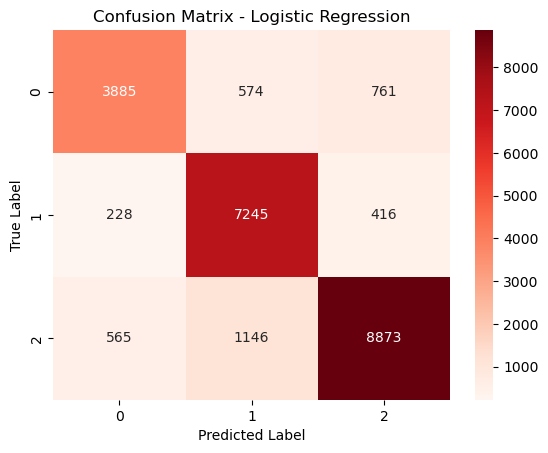

In [67]:
y_test_pred = best_log_reg_model.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test_enc, y_test_pred)
test_precision = precision_score(y_test_enc, y_test_pred, average='macro')
test_recall = recall_score(y_test_enc, y_test_pred, average='macro')
test_f1 = f1_score(y_test_enc, y_test_pred, average='macro')

print("\nTest Accuracy :", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall   :", test_recall)
print("Test F1-score :", test_f1)
print("\nTest Classification Report:")
print(classification_report(y_test_enc, y_test_pred))

cm = confusion_matrix(y_test_enc, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## SVM

In [32]:
from sklearn.svm import SVC  # Support Vector Classifier

### TF–IDF Vectorization

In [34]:
tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    max_features=10000,    # Tune as needed
    ngram_range=(1, 2),    # Optionally use bigrams
    stop_words='english'   # Can remove if you don't want to remove stop words
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)
X_val_tfidf   = tfidf_vectorizer.transform(X_val_texts)
X_test_tfidf  = tfidf_vectorizer.transform(X_test_texts)

### SVM Classifier

In [36]:
from sklearn.svm import LinearSVC

In [37]:
svm_model = LinearSVC(
    C=1.0,             # Regularization parameter
    random_state=42,
    verbose=1          # Enable progress updates
)

# Fit the model
svm_model.fit(X_train_tfidf, y_train_enc)

[LibLinear]iter  1 act 3.465e+04 pre 3.465e+04 delta 5.576e-01 f 1.106e+05 |g| 1.243e+05 CG   1
cg reaches trust region boundary
iter  2 act 1.679e+03 pre 1.679e+03 delta 2.230e+00 f 7.591e+04 |g| 3.141e+03 CG   1
cg reaches trust region boundary
iter  3 act 5.893e+03 pre 5.891e+03 delta 8.921e+00 f 7.423e+04 |g| 4.265e+03 CG   2
cg reaches trust region boundary
iter  4 act 1.417e+04 pre 1.364e+04 delta 1.335e+01 f 6.834e+04 |g| 3.232e+03 CG   2
cg reaches trust region boundary
iter  5 act 1.057e+04 pre 1.036e+04 delta 1.608e+01 f 5.417e+04 |g| 3.498e+03 CG   3
cg reaches trust region boundary
iter  6 act 6.897e+03 pre 6.434e+03 delta 1.837e+01 f 4.360e+04 |g| 3.017e+03 CG   4
cg reaches trust region boundary
iter  7 act 4.095e+03 pre 3.777e+03 delta 2.090e+01 f 3.670e+04 |g| 2.883e+03 CG   6
iter  8 act 1.734e+03 pre 1.615e+03 delta 2.090e+01 f 3.260e+04 |g| 2.123e+03 CG   9
iter  9 act 5.042e+01 pre 5.025e+01 delta 2.090e+01 f 3.087e+04 |g| 1.138e+03 CG   2
iter 10 act 2.812e+02 pre 

LinearSVC(random_state=42, verbose=1)

In [38]:
# Predict on validation
y_val_pred = svm_model.predict(X_val_tfidf)

### Evaluate on the Validation Set

In [60]:
# Evaluate on validation set
val_accuracy = accuracy_score(y_val_enc, y_val_pred)
val_precision = precision_score(y_val_enc, y_val_pred, average='macro')
val_recall = recall_score(y_val_enc, y_val_pred, average='macro')
val_f1 = f1_score(y_val_enc, y_val_pred, average='macro')

print("Validation Accuracy :", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall   :", val_recall)
print("Validation F1-score :", val_f1)
print("\nValidation Classification Report:")
print(classification_report(y_val_enc, y_val_pred))


Validation Accuracy : 0.8438779386316634
Validation Precision: 0.8411187289117569
Validation Recall   : 0.8353177172955735
Validation F1-score : 0.8353879568455849

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      5219
           1       0.80      0.93      0.86      7890
           2       0.89      0.83      0.86     10584

    accuracy                           0.84     23693
   macro avg       0.84      0.84      0.84     23693
weighted avg       0.85      0.84      0.84     23693



### Final Evaluation on Testing Data


Test Accuracy : 0.8475077026969992
Test Precision: 0.8438519310045303
Test Recall   : 0.8377480099708272
Test F1-score : 0.8382317763707815

Test Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      5220
           1       0.81      0.93      0.86      7889
           2       0.89      0.83      0.86     10584

    accuracy                           0.85     23693
   macro avg       0.84      0.84      0.84     23693
weighted avg       0.85      0.85      0.85     23693



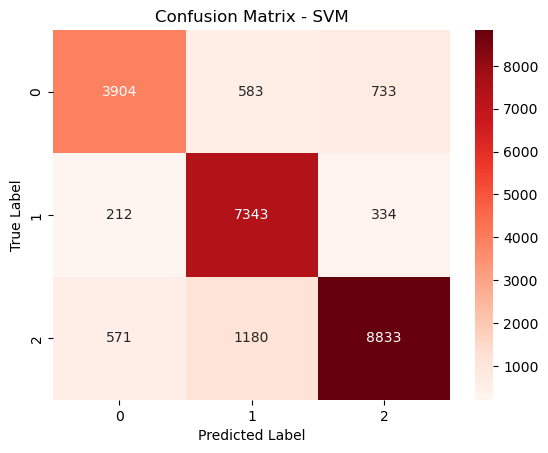

In [65]:
y_test_pred = svm_model.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test_enc, y_test_pred)
test_precision = precision_score(y_test_enc, y_test_pred, average='macro')
test_recall = recall_score(y_test_enc, y_test_pred, average='macro')
test_f1 = f1_score(y_test_enc, y_test_pred, average='macro')

print("\nTest Accuracy :", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall   :", test_recall)
print("Test F1-score :", test_f1)
print("\nTest Classification Report:")
print(classification_report(y_test_enc, y_test_pred))

cm = confusion_matrix(y_test_enc, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## CNN

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

### Build CNN Model

In [83]:
# Define global variables
vocab_size = 10000  # Vocabulary size
input_length = max_len  # Maximum length of padded sequences
num_classes = len(np.unique(y_train_enc))  # Number of output classes

In [85]:
def build_model(hp):
    """
    Build a CNN model with tunable hyperparameters for text classification.
    :param hp: Hyperparameter object from Keras Tuner
    :return: Compiled Keras model
    """
    model = Sequential()

    # Embedding layer
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Choice('embedding_dim', [50, 100, 200]),  # Tune embedding dimensions
        input_length=input_length
    ))
    
    # Convolutional layer
    model.add(Conv1D(
        filters=hp.Choice('filters', [64, 128, 256]),   # Tune number of filters
        kernel_size=hp.Choice('kernel_size', [3, 5, 7]), # Tune kernel size
        activation='relu'
    ))
    model.add(GlobalMaxPooling1D())
    
    # Dense layer
    model.add(Dense(
        hp.Choice('dense_units', [32, 64, 128]),  # Tune number of units in Dense layer
        activation='relu'
    ))
    model.add(Dropout(hp.Choice('dropout', [0.3, 0.5, 0.7])))  # Tune dropout rate
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),  # Tune learning rate
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Setup Keras Tuner

In [88]:
tuner = kt.RandomSearch(
    build_model,  # Pass the model-building function
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=10,             # Number of hyperparameter combinations to try
    executions_per_trial=1,    # Number of times to train each model configuration
    directory='tuning_results',  # Folder to save tuning logs
    project_name='cnn_text_classification'
)

/Users/jack/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Hyperparameter Search

In [91]:
tuner.search(
    X_train_pad, 
    y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=5,  # You can increase this to allow more training for each trial
    batch_size=32,  # Fixed for now, or you can also tune it
    verbose=1
)

Trial 10 Complete [00h 03m 30s]
val_accuracy: 0.8981555700302124

Best val_accuracy So Far: 0.9011522531509399
Total elapsed time: 00h 54m 25s


In [93]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"Best Number of Filters: {best_hps.get('filters')}")
print(f"Best Kernel Size: {best_hps.get('kernel_size')}")
print(f"Best Dense Units: {best_hps.get('dense_units')}")
print(f"Best Dropout Rate: {best_hps.get('dropout')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

Best Embedding Dimension: 200
Best Number of Filters: 128
Best Kernel Size: 7
Best Dense Units: 128
Best Dropout Rate: 0.3
Best Learning Rate: 0.0001


### Train the Model

In [97]:
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train_pad, 
    y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=5,  # Train for more epochs with the best configuration
    batch_size=32,  # Fixed for now
    verbose=1
)

Epoch 1/5
3456/3456 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - accuracy: 0.6394 - loss: 0.8007 - val_accuracy: 0.8875 - val_loss: 0.3451
Epoch 2/5
3456/3456 ━━━━━━━━━━━━━━━━━━━━ 80s 23ms/step - accuracy: 0.9017 - loss: 0.3048 - val_accuracy: 0.9006 - val_loss: 0.3176
Epoch 3/5
3456/3456 ━━━━━━━━━━━━━━━━━━━━ 79s 23ms/step - accuracy: 0.9207 - loss: 0.2503 - val_accuracy: 0.9007 - val_loss: 0.3184
Epoch 4/5
3456/3456 ━━━━━━━━━━━━━━━━━━━━ 79s 23ms/step - accuracy: 0.9381 - loss: 0.2026 - val_accuracy: 0.8980 - val_loss: 0.3287
Epoch 5/5
3456/3456 ━━━━━━━━━━━━━━━━━━━━ 78s 23ms/step - accuracy: 0.9558 - loss: 0.1525 - val_accuracy: 0.8909 - val_loss: 0.3566


### Evaluate the test set

741/741 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Test Accuracy:  0.8927
Test Precision: 0.8925
Test Recall:    0.8927
Test F1-score:  0.8925

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      5220
           1       0.90      0.93      0.92      7889
           2       0.91      0.90      0.90     10584

    accuracy                           0.89     23693
   macro avg       0.88      0.88      0.88     23693
weighted avg       0.89      0.89      0.89     23693



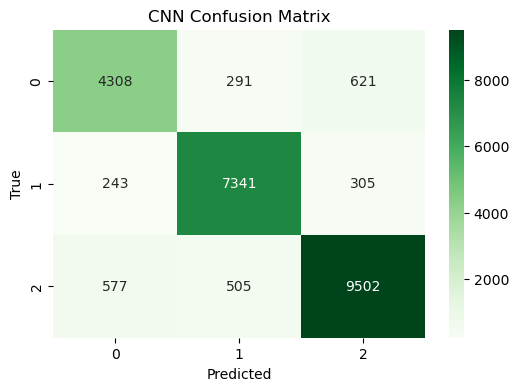

In [104]:
# Predictions
y_pred_probs = best_model.predict(X_test_pad)  # Use the best_model from hyperparameter tuning
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions

# Metrics
accuracy = accuracy_score(y_test_enc, y_pred)
precision = precision_score(y_test_enc, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_enc, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test_enc, y_pred, average='weighted', zero_division=0)

print("Test Accuracy:  {:.4f}".format(accuracy))
print("Test Precision: {:.4f}".format(precision))
print("Test Recall:    {:.4f}".format(recall))
print("Test F1-score:  {:.4f}".format(f1))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(y_test_enc), yticklabels=np.unique(y_test_enc))
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Plot Training History

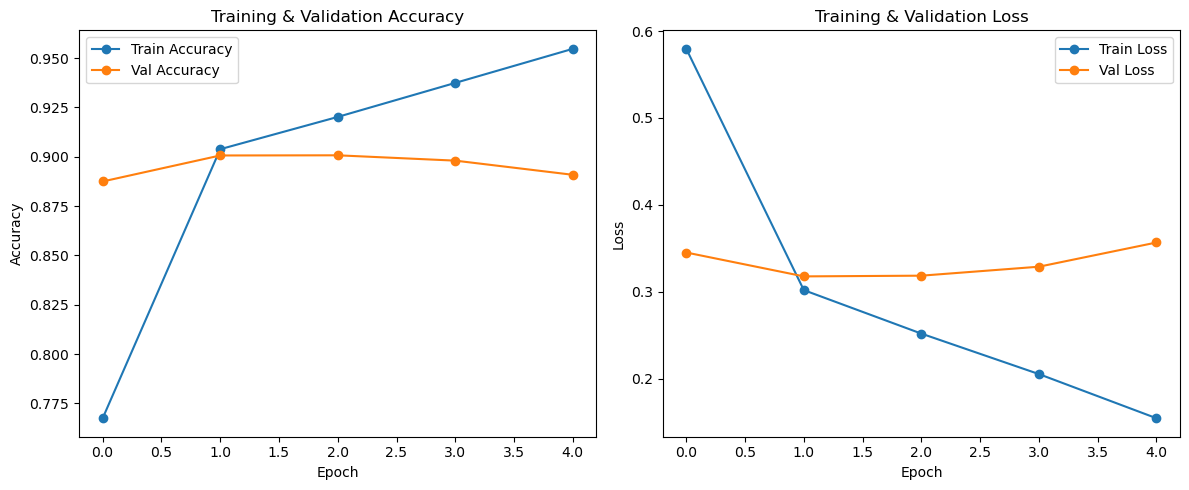

In [106]:
def plot_training_history(history):
    """
    Plots the accuracy and loss curves from the training history.
    """
    # Accuracy
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

## RNN (Abandoned)

In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

In [ ]:
# Hyperparameters
vocab_size    = 10000   # Should match the tokenizer.num_words if used
embedding_dim = 100
input_length  = X_train_pad.shape[1]  # The max_len used for padding
num_classes   = len(np.unique(y_train_enc))

### Build RNN Model 

In [ ]:
def build_rnn_model(vocab_size, embedding_dim, input_length, num_classes):
    """
    Build a simple RNN model for text classification.
    :param vocab_size: size of vocabulary for embedding layer
    :param embedding_dim: dimension of the embeddings
    :param input_length: maximum length of input sequences
    :param num_classes: number of output classes
    :return: compiled Keras model
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=input_length))
    
    # Simple Recurrent Layer
    model.add(SimpleRNN(128, activation='relu'))  
    # You can also try activation='tanh' or different units

    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

### Train the Model

In [ ]:
rnn_model = build_rnn_model(vocab_size, embedding_dim, input_length, num_classes)
rnn_model.build(input_shape=(None, input_length))
print(rnn_model.summary())

batch_size = 32
epochs     = 5

history_rnn = rnn_model.fit(
    X_train_pad, 
    y_train_enc, 
    validation_data=(X_val_pad, y_val_enc),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)


### Evaluate on Test Set

In [ ]:
y_pred_probs_rnn = rnn_model.predict(X_test_pad)
y_pred_rnn        = np.argmax(y_pred_probs_rnn, axis=1)

# Calculate metrics
accuracy_rnn  = accuracy_score(y_test_enc, y_pred_rnn)
precision_rnn = precision_score(y_test_enc, y_pred_rnn, average='weighted', zero_division=0)
recall_rnn    = recall_score(y_test_enc, y_pred_rnn, average='weighted', zero_division=0)
f1_rnn        = f1_score(y_test_enc, y_pred_rnn, average='weighted', zero_division=0)

print("RNN Test Accuracy:  {:.4f}".format(accuracy_rnn))
print("RNN Test Precision: {:.4f}".format(precision_rnn))
print("RNN Test Recall:    {:.4f}".format(recall_rnn))
print("RNN Test F1-score:  {:.4f}".format(f1_rnn))

print("\nRNN Classification Report:")
print(classification_report(y_test_enc, y_pred_rnn, zero_division=0))

# Confusion Matrix
cm_rnn = confusion_matrix(y_test_enc, y_pred_rnn)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues')
plt.title('RNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Plot Training History

In [ ]:
def plot_training_history_rnn(history):
    """
    Plots the accuracy and loss curves from the RNN training history.
    """
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('RNN: Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('RNN: Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history_rnn(history_rnn)

## LSTM

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [112]:
def build_lstm_model(hp):
    """
    Build an LSTM model with tunable hyperparameters for text classification.
    :param hp: Hyperparameter object from Keras Tuner
    :return: Compiled Keras model
    """
    model = Sequential()
    
    # Embedding layer with tunable embedding dimensions
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Choice('embedding_dim', [50, 100, 200]),  # Tune embedding dimensions
        input_length=input_length
    ))
    
    # LSTM layer with tunable units
    model.add(LSTM(
        units=hp.Choice('lstm_units', [64, 128, 256]),  # Tune number of units in LSTM
        return_sequences=False, 
        activation='tanh'
    ))
    
    # Dropout layer with tunable dropout rate
    model.add(Dropout(hp.Choice('dropout', [0.3, 0.5, 0.7])))

    # Dense layer with tunable units
    model.add(Dense(
        units=hp.Choice('dense_units', [32, 64, 128]),  # Tune number of units in Dense layer
        activation='relu'
    ))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),  # Tune learning rate
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Initialize the Keras Tuner

In [132]:
# Initialize the tuner
tuner = kt.RandomSearch(
    build_lstm_model,  # Pass the model-building function
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=5,  # Number of combinations to try
    directory='lstm_tuning_results',  # Save tuning logs here
    project_name='lstm_text_classification'  # Name of the project
)

### Hyperparameter Search

In [141]:
# Perform the hyperparameter search
tuner.search(
    X_train_pad, 
    y_train_enc, 
    validation_data=(X_val_pad, y_val_enc),
    epochs=5,  # You can increase this for better tuning
    batch_size=32,  # Fixed batch size for now; can also tune this
    verbose=1
)

Epoch 1/5


/Users/jack/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3456/3456 ━━━━━━━━━━━━━━━━━━━━ 987s 285ms/step - accuracy: 0.4445 - loss: 1.0745 - val_accuracy: 0.4467 - val_loss: 1.0595
Epoch 2/5
  29/3456 ━━━━━━━━━━━━━━━━━━━━ 15:46 276ms/step - accuracy: 0.4302 - loss: 1.0734

KeyboardInterrupt: 

### Train the model

In [ ]:
lstm_model = build_lstm_model(
    vocab_size=vocab_size, 
    embedding_dim=embedding_dim, 
    input_length=input_length, 
    num_classes=num_classes
)
lstm_model.build(input_shape=(None, input_length))
print(lstm_model.summary())

batch_size = 32
epochs     = 5

history_lstm = lstm_model.fit(
    X_train_pad, 
    y_train_enc, 
    validation_data=(X_val_pad, y_val_enc),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

### Evaluate the test set

In [ ]:
y_pred_probs_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm       = np.argmax(y_pred_probs_lstm, axis=1)

accuracy_lstm  = accuracy_score(y_test_enc, y_pred_lstm)
precision_lstm = precision_score(y_test_enc, y_pred_lstm, average='weighted', zero_division=0)
recall_lstm    = recall_score(y_test_enc, y_pred_lstm, average='weighted', zero_division=0)
f1_lstm        = f1_score(y_test_enc, y_pred_lstm, average='weighted', zero_division=0)

print("LSTM Test Accuracy:  {:.4f}".format(accuracy_lstm))
print("LSTM Test Precision: {:.4f}".format(precision_lstm))
print("LSTM Test Recall:    {:.4f}".format(recall_lstm))
print("LSTM Test F1-score:  {:.4f}".format(f1_lstm))

print("\nLSTM Classification Report:")
print(classification_report(y_test_enc, y_pred_lstm, zero_division=0))

# Confusion Matrix
cm_lstm = confusion_matrix(y_test_enc, y_pred_lstm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Plot the training history

In [ ]:
def plot_training_history_lstm(history):
    """
    Plots the accuracy and loss curves from the LSTM training history.
    """
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)a
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('LSTM: Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('LSTM: Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history_lstm(history_lstm)

## FinBert

In [ ]:
import numpy as np
import pandas as pd
import torch
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict

In [ ]:
train_df = pd.DataFrame({
    'text': df_x_train['Cleaned_Tweet'].tolist(),
    'label': y_train_enc
})
val_df = pd.DataFrame({
    'text': df_x_validate['Cleaned_Tweet'].tolist(),
    'label': y_val_enc
})
test_df = pd.DataFrame({
    'text': df_x_test['Cleaned_Tweet'].tolist(),
    'label': y_test_enc
})

hf_train_dataset = Dataset.from_pandas(train_df)
hf_val_dataset   = Dataset.from_pandas(val_df)
hf_test_dataset  = Dataset.from_pandas(test_df)

dataset_dict = DatasetDict({
    'train': hf_train_dataset,
    'validation': hf_val_dataset,
    'test': hf_test_dataset
})

### Load FinBERT tokenizer & model

In [ ]:
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(np.unique(y_train_enc)))

### Tokenize function

In [ ]:
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)

tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)

In [ ]:
# Set format for Pytorch
tokenized_dataset.set_format("torch")

### Define Metric Function

In [ ]:
accuracy_metric  = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric    = evaluate.load("recall")
f1_metric        = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc  = accuracy_metric.compute(predictions=predictions, references=labels)
    prec = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    rec  = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    f1   = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    
    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1["f1"]
    }

### Training

In [ ]:
training_args = TrainingArguments(
    output_dir="finbert-sentiment-checkpoints",
    evaluation_strategy="epoch",     # Evaluate every epoch
    save_strategy="epoch",           # Save checkpoints every epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="finbert-logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1"       # We'll use F1 to pick best model
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
train_result = trainer.train()
trainer.save_model("finbert-sentiment-model")  # Save final model

### Evaluate on Validation and Test set


In [ ]:
print("Validation Set Evaluation:")
val_metrics = trainer.evaluate(eval_dataset=tokenized_dataset["validation"])
print(val_metrics)

print("\nTest Set Evaluation:")
test_metrics = trainer.evaluate(eval_dataset=tokenized_dataset["test"])
print(test_metrics)

### Predictions

In [ ]:
predictions_output = trainer.predict(tokenized_dataset["test"])
logits = predictions_output.predictions
labels = predictions_output.label_ids

predictions = np.argmax(logits, axis=-1)

# Confusion matrix
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('FinBERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# If you want classification report via sklearn:
from sklearn.metrics import classification_report
print("Classification Report (Test Set):")
print(classification_report(labels, predictions, zero_division=0))

## Reddit

### Data Cleaning

In [137]:
# Function to clean tweets

# Convert all entries in 'comment' column to strings
df_reddit['comment'] = df_reddit['comment'].astype(str)

# Convert all entries in 'text' column to strings
df_reddit['Cleaned_Comment'] = df_reddit['comment'].astype(str)

def clean_comment(comment):
    # Remove mentions (@username)
    comment = re.sub(r'@\w+', '', comment)
    # Remove URLs
    comment = re.sub(r'http\S+|www\S+|https\S+', '', comment, flags=re.MULTILINE)
    # Remove special characters, numbers, and punctuations
    comment = re.sub(r'\W', ' ', comment)
    # Remove extra spaces
    comment = re.sub(r'\s+', ' ', comment).strip()
    # Convert to lowercase
    comment = comment.lower()
    return comment

# Apply the cleaning function to the 'Tweet' column
df_reddit['Cleaned_Comment'] = df_reddit['comment'].apply(clean_comment)

In [139]:
# Tokenization
df_reddit['Tokens'] = df_reddit['Cleaned_Comment'].apply(word_tokenize)

# Removing Stopwords 
stop_words = set(stopwords.words('english'))
df_reddit['Tokens'] = df_reddit['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df_reddit['Tokens'] = df_reddit['Tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

## Financial News

In [ ]:
df_news.head()